In [ ]:
!pip install --quiet -U optuna neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
import yfinance as yf

# Descargar datos de los 8 tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%***********************]  8 of 8 completed


In [ ]:
horizon = 1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from neuralforecast import NeuralForecast
from neuralforecast.models import TiDE
from neuralforecast.losses.pytorch import SMAPE
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import smape as smape_cv, mape as mape_cv, mae as mae_cv, mse as mse_cv, rmse as rmse_cv
import logging
import warnings

# Configuraciones para ignorar advertencias
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Función objetivo para cada serie temporal
def objective(trial, df_serie):
    try:
        # Definir los hiperparámetros a optimizar
        hidden_size = trial.suggest_categorical('hidden_size', [256, 512, 1024])
        input_size = trial.suggest_int('input_size', 1, 3)
        num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 3)
        num_decoder_layers = trial.suggest_int('num_decoder_layers', 1, 3)
        decoder_output_dim = trial.suggest_categorical('decoder_output_dim', [4, 8, 16, 32])
        temporal_decoder_dim = trial.suggest_categorical('temporal_decoder_dim', [32, 64, 128])
        dropout = trial.suggest_categorical('dropout', [0.0, 0.1, 0.2, 0.3, 0.5])
        layernorm = trial.suggest_categorical('layernorm', [True, False])
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

        # Crear el modelo TiDE
        model = TiDE(
            h=horizon,
            input_size=input_size,
            hidden_size=hidden_size,
            decoder_output_dim=decoder_output_dim,
            temporal_decoder_dim=temporal_decoder_dim,
            dropout=dropout,
            layernorm=layernorm,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            learning_rate=learning_rate,
            loss=SMAPE(),
            enable_progress_bar=False
        )

        # Crear y ajustar el modelo
        nf = NeuralForecast(models=[model], freq='D')

        # Validación cruzada
        cv_df = nf.cross_validation(df_serie, n_windows=3, step_size=horizon)
        cv_df = cv_df.reset_index()

        # Evaluar las predicciones
        evaluation_df = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'],
                                 metrics=[smape_cv, mape_cv, mae_cv, mse_cv, rmse_cv])

        smape = evaluation_df[evaluation_df['metric'] == 'smape']['TiDE'].values[0]
        mape = evaluation_df[evaluation_df['metric'] == 'mape']['TiDE'].values[0]
        mae = evaluation_df[evaluation_df['metric'] == 'mae']['TiDE'].values[0]
        mse = evaluation_df[evaluation_df['metric'] == 'mse']['TiDE'].values[0]
        rmse = evaluation_df[evaluation_df['metric'] == 'rmse']['TiDE'].values[0]

        # Guardar métricas en los atributos del trial
        trial.set_user_attr('mape', mape)
        trial.set_user_attr('mae', mae)
        trial.set_user_attr('mse', mse)
        trial.set_user_attr('rmse', rmse)

        return smape
    except Exception as e:
        print(f"Error en el trial para el ticker: {df_serie['unique_id'].unique()[0]}: {e}")
        raise optuna.exceptions.TrialPruned()

# Iterar sobre cada serie temporal (asegúrate de tener 'tickers' definidos)
for ticker in tickers:
    print(f"Optimizando para {ticker}")

    # Filtrar los datos por ticker
    df_ticker = Y_df[Y_df['unique_id'] == ticker].reset_index(drop=True)

    # Crear el estudio de Optuna para cada ticker
    study = optuna.create_study(direction='minimize')

    # Optimizar los hiperparámetros
    study.optimize(lambda trial: objective(trial, df_ticker), n_trials=30)

    # Si el estudio tiene éxito, se imprimen los mejores resultados
    if study.best_trial:
        best_trial = study.best_trial
        mape = best_trial.user_attrs['mape']
        mae = best_trial.user_attrs['mae']
        mse = best_trial.user_attrs['mse']
        rmse = best_trial.user_attrs['rmse']

        print("Mejores hiperparámetros:", study.best_params)
        print("Mejor SMAPE:", study.best_value)
        print(f'Best MAPE: {mape}')
        print(f'Best MAE: {mae}')
        print(f'Best MSE: {mse}')
        print(f'Best RMSE: {rmse}')
    else:
        print("No hay trials completados exitosamente.")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
INFO:lightning_fabric.utilities.seed:Seed set to 1


Optimizando para AAPL


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 1024, 'input_size': 2, 'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_dim': 128, 'dropout': 0.1, 'layernorm': False, 'learning_rate': 8.922611893437769e-05}
Mejor SMAPE: 0.003594876841171849
Best MAPE: 0.007144341454086849
Best MAE: 1.6568603515625
Best MSE: 5.522818615815292
Best RMSE: 2.3500677896212467
Optimizando para MSFT


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 512, 'input_size': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_dim': 32, 'dropout': 0.2, 'layernorm': True, 'learning_rate': 0.0006234242924278077}
Mejor SMAPE: 0.0020063029980494523
Best MAPE: 0.004031171787602389
Best MAE: 1.726776123046875
Best MSE: 6.8732881449783845
Best RMSE: 2.6216956621580594
Optimizando para GOOGL


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 512, 'input_size': 3, 'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_dim': 128, 'dropout': 0.3, 'layernorm': False, 'learning_rate': 0.0002933821365955944}
Mejor SMAPE: 0.001799216788596037
Best MAPE: 0.0035901068952390973
Best MAE: 0.591766357421875
Best MSE: 0.4541674191132188
Best RMSE: 0.6739194455669155
Optimizando para AMZN


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 512, 'input_size': 3, 'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_dim': 32, 'dropout': 0.5, 'layernorm': False, 'learning_rate': 0.0001412653223116321}
Mejor SMAPE: 0.0017781507168996913
Best MAPE: 0.0035692926976526144
Best MAE: 0.67169189453125
Best MSE: 0.9509206196914116
Best RMSE: 0.9751515880576781
Optimizando para NVDA


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 256, 'input_size': 1, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_dim': 64, 'dropout': 0.3, 'layernorm': False, 'learning_rate': 0.0018980836943787278}
Mejor SMAPE: 0.004478458605781829
Best MAPE: 0.009025111540367585
Best MAE: 1.100079854329427
Best MSE: 2.2972078320453875
Best RMSE: 1.5156542587428663
Optimizando para META


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 256, 'input_size': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_dim': 32, 'dropout': 0.2, 'layernorm': True, 'learning_rate': 0.0030207667379797652}
Mejor SMAPE: 0.0017906257491886511
Best MAPE: 0.0035708124563371864
Best MAE: 2.0396728515625
Best MSE: 7.440472962955634
Best RMSE: 2.7277230363355502
Optimizando para IBM


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 512, 'input_size': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_dim': 32, 'dropout': 0.5, 'layernorm': True, 'learning_rate': 0.0047606490260228}
Mejor SMAPE: 0.003216827385649593
Best MAPE: 0.006414922090056133
Best MAE: 1.4273885091145833
Best MSE: 3.233885458825777
Best RMSE: 1.7983007142371314
Optimizando para BTC-USD


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities

Mejores hiperparámetros: {'hidden_size': 512, 'input_size': 3, 'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_dim': 64, 'dropout': 0.3, 'layernorm': False, 'learning_rate': 1.6598254218150528e-05}
Mejor SMAPE: 0.005318164596863582
Best MAPE: 0.010753245897515133
Best MAE: 688.22265625
Best MSE: 1030916.9438323975
Best RMSE: 1015.3408018160195


In [ ]:
import time

# Lista para almacenar los resultados de las predicciones
predictions_list = []

# Iterar sobre cada serie temporal
for ticker in Y_df['unique_id'].unique():
    print(f"Generando predicción para {ticker}")

    # Crear el modelo TiDE con los mejores hiperparámetros
    model_TiDE = TiDE(h=horizon, **study.best_params)
    nf = NeuralForecast(models=[model_TiDE], freq='D')

    # Filtrar los datos por ticker
    df_ticker = Y_df[Y_df['unique_id'] == ticker].reset_index(drop=True)

    # Separar los datos en entrenamiento y prueba
    prediction_length = int(len(df_ticker)) - horizon
    Y_df_real = df_ticker[:prediction_length]
    Y_df_test = df_ticker[prediction_length:]

    # Ajustar el modelo con los datos de entrenamiento
    nf.fit(Y_df_real)

    # Realizar la predicción
    predict_start = time.time()
    forecast_df = nf.predict(Y_df_real)
    predict_end = time.time()

    # Calcular el tiempo de predicción
    predict_time = predict_end - predict_start
    print(f"Tiempo de predicción: {predict_time:.2f} segundos")

    # Agregar ticker a las predicciones
    forecast_df['unique_id'] = ticker
    predictions_list.append(forecast_df)

# Concatenar todas las predicciones en un solo DataFrame
all_forecast_df = pd.concat(predictions_list)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Generando predicción para AAPL


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.24 segundos
Generando predicción para AMZN


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.27 segundos
Generando predicción para BTC-USD


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.22 segundos
Generando predicción para GOOGL


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.34 segundos
Generando predicción para IBM


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.33 segundos
Generando predicción para META


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.18 segundos
Generando predicción para MSFT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1


Tiempo de predicción: 0.26 segundos
Generando predicción para NVDA


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Tiempo de predicción: 0.73 segundos


In [ ]:
all_forecast_df

,ds,TiDE,unique_id
unique_id,,,
AAPL,2024-09-28 00:00:00+00:00,225.443115,AAPL
AMZN,2024-09-28 00:00:00+00:00,187.738693,AMZN
BTC-USD,2024-09-30 00:00:00+00:00,65062.320312,BTC-USD
GOOGL,2024-09-28 00:00:00+00:00,163.090286,GOOGL
IBM,2024-09-28 00:00:00+00:00,220.888000,IBM
META,2024-09-28 00:00:00+00:00,566.090149,META
MSFT,2024-09-28 00:00:00+00:00,426.511536,MSFT
NVDA,2024-09-28 00:00:00+00:00,119.435028,NVDA


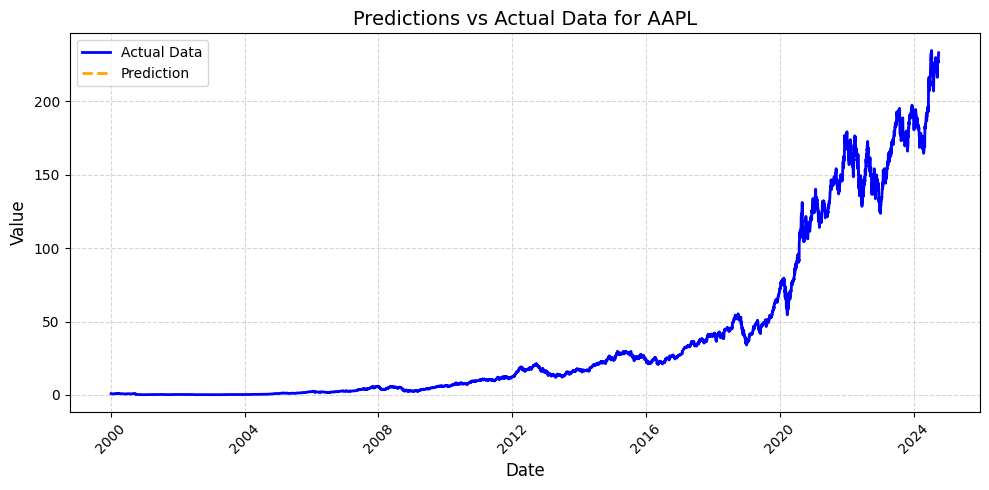

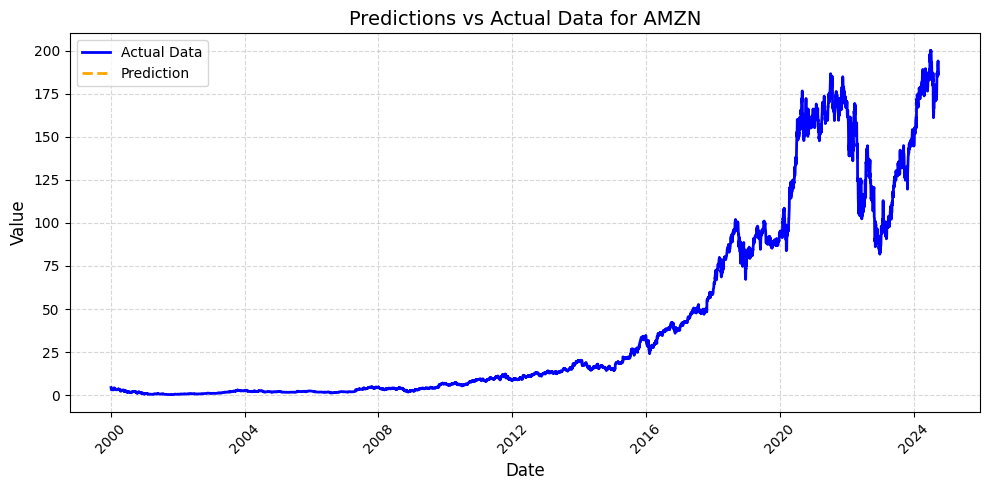

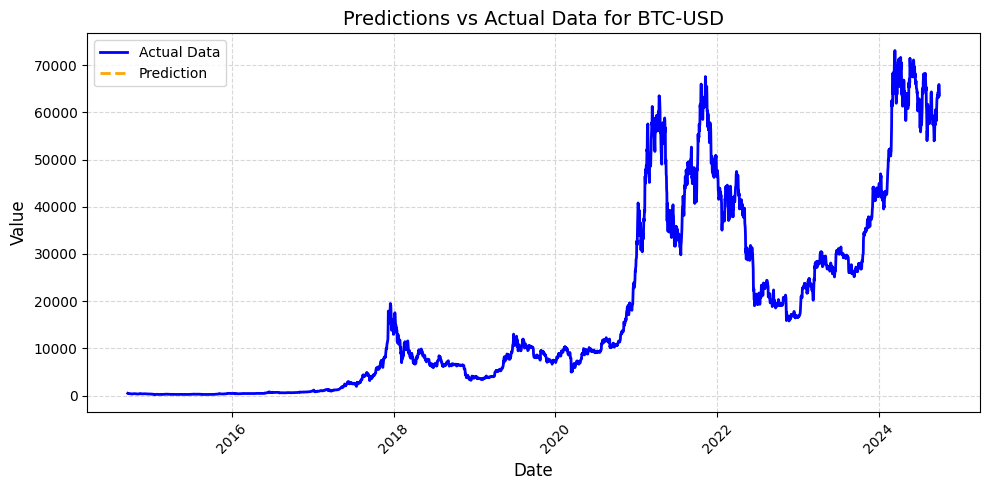

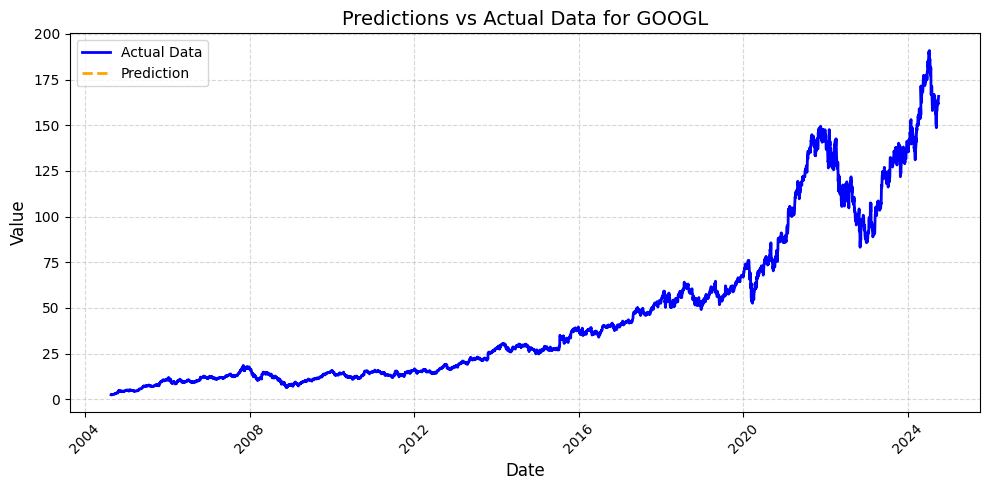

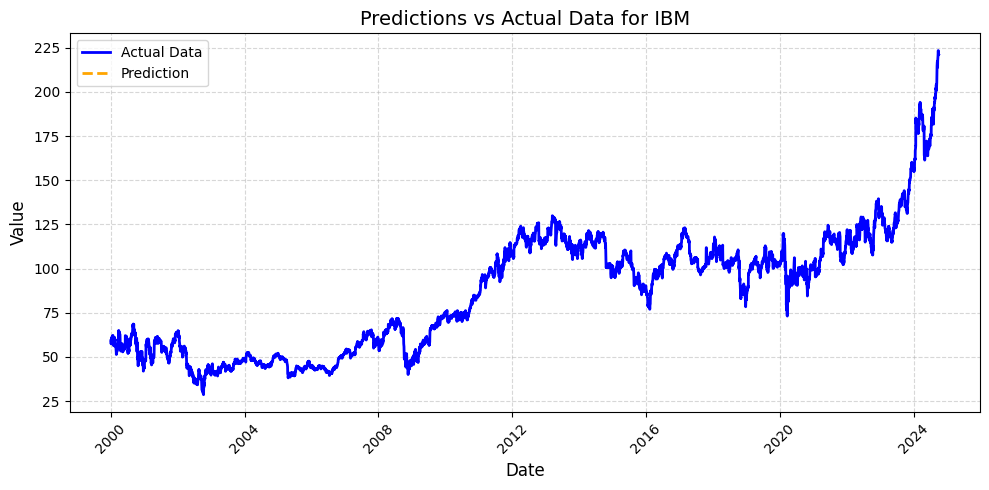

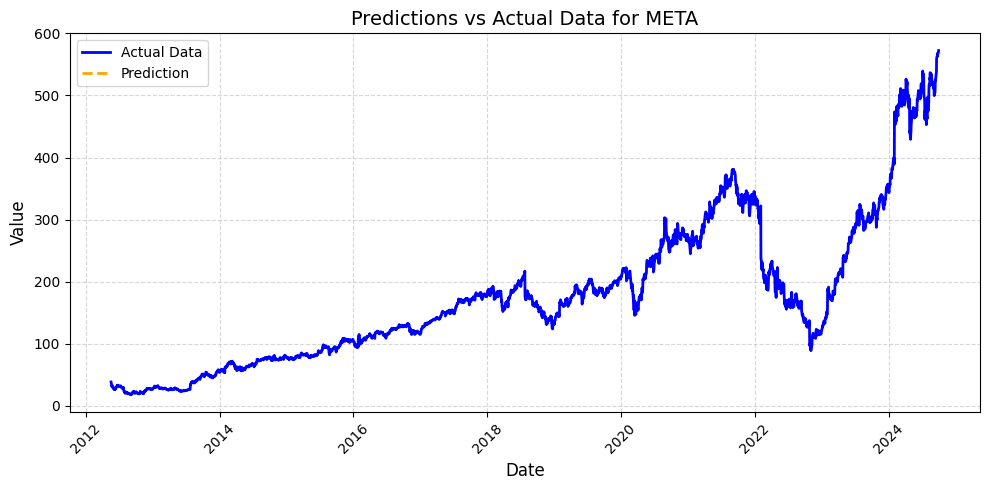

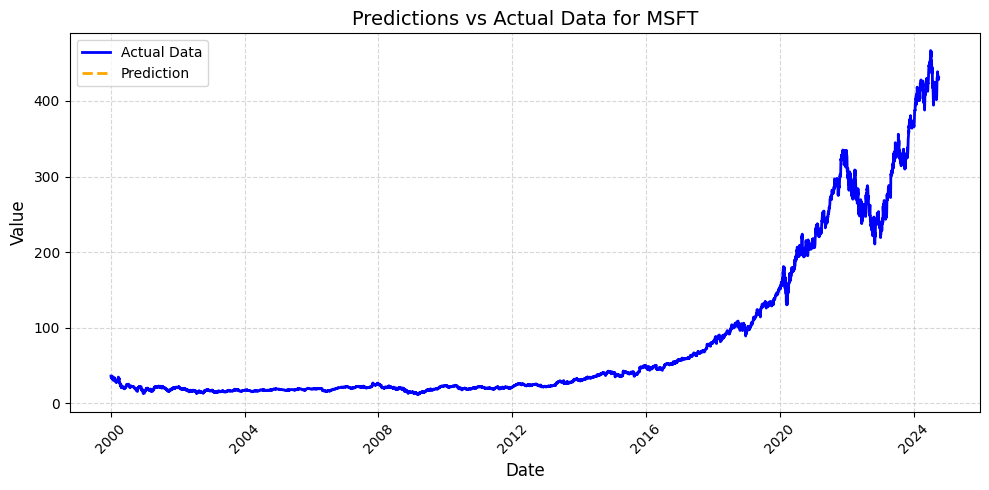

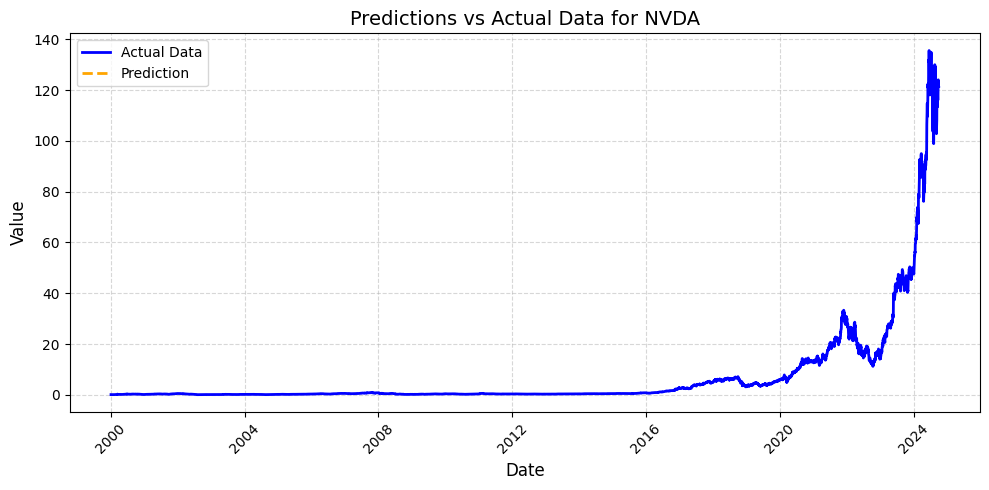

In [ ]:
# Plotting predictions for each time series
for ticker in all_forecast_df['unique_id'].unique():
    plt.figure(figsize=(10, 5))

    # Filter predictions and actual data by ticker
    forecast_data = all_forecast_df[all_forecast_df['unique_id'] == ticker]
    actual_data = Y_df[Y_df['unique_id'] == ticker]

    # Plot actual data as a solid line
    plt.plot(actual_data['ds'], actual_data['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Plot predictions as a dashed line
    plt.plot(forecast_data['ds'], forecast_data['TiDE'], label='Prediction', linestyle='--', color='orange', linewidth=2)

    # Configure the plot
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Show the plot
    plt.show()